# Task 6 :Quantum Representation Learning

First we will import all the required libraries for the task

In [15]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

## MNIST Dataset

The MNIST dataset has images 28x28 pixels<br>

We can split the image in 4 parts for quantum encoding<br>

Therefore we will be using 4 qubit for each image

total_wires = 2 register of each qubit + one ancilla qubit for swap test

In [2]:
n_qubits_per_state = 4
total_wires = 1 + 2 * n_qubits_per_state  
dev = qml.device("default.qubit", wires=total_wires)

Seed initialization is used for random operations

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Dataset Preprocessing

Just split the image in 4 quadrants 
Return a tensor of this vector


In [4]:
def preprocess_image(img):
    img_np = img.numpy()
    q1 = np.mean(img_np[:14, :14])
    q2 = np.mean(img_np[:14, 14:])
    q3 = np.mean(img_np[14:, :14])
    q4 = np.mean(img_np[14:, 14:])
    return torch.tensor([q1, q2, q3, q4], dtype=torch.float32)

The encode_image function will encode the image by applying rotation gates

Rotation angle is given by:<br>
    θi =scale[i] × image[i] + bias[i]

    



In [5]:
def encode_image(image, params, wires):
    for i, wire in enumerate(wires):
        theta = params[i, 0] * image[i] + params[i, 1]
        qml.RY(theta, wires=wire)

### Swap Circuit

We will encode first image on wire 1 to 4 and second image on wire 5 to 8
Both are encoded using same encoder and parameter

The hamdard gate is applied to ancilla qubit ie q0 

Then we apply Controlled Swap ie CSWAP on one qubit from each image

Finally again Hamdard gate on ancilla 

The expectation value of the Pauli‑Z operator on the ancilla is measured. This value relates directly to the fidelity (similarity) between the two quantum states. If fidelity close to 1 means the states are similar, while a fidelity near 0 indicates dissimilarity.


In [6]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(image1, image2, params):
    
    encode_image(image1, params, wires=list(range(1, n_qubits_per_state + 1)))
    
    encode_image(image2, params, wires=list(range(n_qubits_per_state + 1, total_wires)))
    
    qml.Hadamard(wires=0)
    for i in range(n_qubits_per_state):
        qml.CSWAP(wires=[0, 1 + i, n_qubits_per_state + 1 + i])
    qml.Hadamard(wires=0)

    return qml.expval(qml.PauliZ(0))

Wrapping these above functionality in a class

In [7]:
class QuantumNet(torch.nn.Module):
    def __init__(self):
        super(QuantumNet, self).__init__()
        self.params = torch.nn.Parameter(torch.randn(n_qubits_per_state, 2))
        
    def forward(self, img1, img2):
        
        proc_img1 = preprocess_image(img1)
        proc_img2 = preprocess_image(img2)
        
        fidelity = quantum_circuit(proc_img1, proc_img2, self.params)
        return fidelity

Loss function

Same Class (label = 1):
The loss is (1−fidelity)^2
Minimizing this loss encourages the fidelity to approach 1.


Different Class (label = 0):
The loss is fidility^2
Minimizing this loss pushes the fidelity toward 0.


In [8]:
def contrastive_loss(fidelity, label):
    # When label==1 (same class): loss = (1 - fidelity)^2
    # When label==0 (different): loss = (fidelity)^2
    return label * (1 - fidelity)**2 + (1 - label) * (fidelity)**2

Load the MNIST dataset

First convert the image to pyTorch tensor

Remove channel dimension using lambda fxn

Due to memory constraint working only with first 10000 smaples

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0))#remove the channel dimension
])
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

data = [(mnist_train[i][0], mnist_train[i][1]) for i in range(10000)]

### Visualising the dataset

To check the shape, label and how pixels are distributed in the dataset

Image #0
 - Shape: torch.Size([28, 28])
 - Label: 5
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.1377
------------------------------
Image #1
 - Shape: torch.Size([28, 28])
 - Label: 0
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.1555
------------------------------
Image #2
 - Shape: torch.Size([28, 28])
 - Label: 4
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.0973
------------------------------
Image #3
 - Shape: torch.Size([28, 28])
 - Label: 1
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.0857
------------------------------
Image #4
 - Shape: torch.Size([28, 28])
 - Label: 9
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.1161
------------------------------
Image #5
 - Shape: torch.Size([28, 28])
 - Label: 2
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.1481
------------------------------
Image #6
 - Shape: torch.Size([28, 28])
 - Label: 1
 - Min pixel: 0.0000
 - Max pixel: 1.0000
 - Mean pixel: 0.0883
--

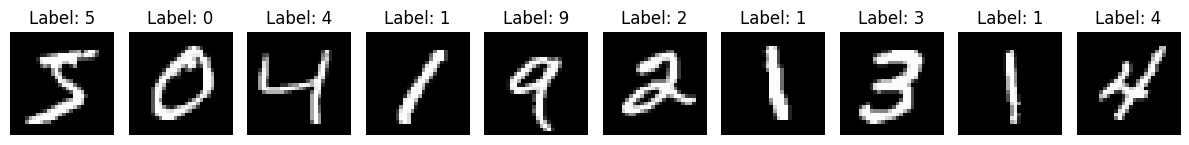

In [16]:
# Function to show and describe images
def show_and_describe_images(dataset, num_images=5):
    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        img, label = dataset[i]

        # Show image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

        # Print image info
        print(f"Image #{i}")
        print(f" - Shape: {img.shape}")
        print(f" - Label: {label}")
        print(f" - Min pixel: {img.min().item():.4f}")
        print(f" - Max pixel: {img.max().item():.4f}")
        print(f" - Mean pixel: {img.mean().item():.4f}")
        print("-" * 30)

    plt.tight_layout()
    plt.show()

# Show images and details
show_and_describe_images(mnist_train, num_images=10)


## Final Training Loop 

An instance of `QuantumNet` is created, and an Adam optimizer is set up with a learning rate of **0.01** to update the trainable parameters.

### Training Parameters
The loop runs for **20 epochs**, with **200 iterations per epoch**.

### Sampling Image Pairs
In each iteration:
- Two random indices are chosen to sample a pair from the dataset.
- The corresponding images and labels are retrieved.
- The target for the contrastive loss is set to **1.0** if the images have the same label, and **0.0** otherwise.

- The **average loss per epoch** is printed, providing insight into the training progress.


In [14]:
qnet = QuantumNet()
optimizer = optim.Adam(qnet.parameters(), lr=0.02)

num_epochs = 40
num_iterations = 200
best_acc=0
for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0  # Track correct classifications
    for _ in range(num_iterations):
        idx1, idx2 = np.random.randint(0, len(data)), np.random.randint(0, len(data))
        img1, label1 = data[idx1]
        img2, label2 = data[idx2]
        target = 1.0 if label1 == label2 else 0.0  # Ground truth label

        optimizer.zero_grad()
        fidelity = qnet(img1, img2)
        loss = contrastive_loss(fidelity, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute accuracy
        predicted_label = 1.0 if fidelity >= 0.5 else 0.0  # Classification threshold
        if predicted_label == target:
            correct_predictions += 1

    avg_loss = total_loss / num_iterations
    accuracy = correct_predictions / num_iterations * 100  # Convert to percentage
    if(accuracy > best_acc):
        best_acc = accuracy
        #torch.save(qnet.state_dict(), "best_model.pth")
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

print(f"Best Accuracy: {best_acc:.2f}%")


Epoch 1, Loss: 0.8578, Accuracy: 7.50%
Epoch 2, Loss: 0.6707, Accuracy: 9.00%
Epoch 3, Loss: 0.4340, Accuracy: 33.50%
Epoch 4, Loss: 0.3515, Accuracy: 46.00%
Epoch 5, Loss: 0.2970, Accuracy: 52.00%
Epoch 6, Loss: 0.2762, Accuracy: 56.00%
Epoch 7, Loss: 0.2227, Accuracy: 68.00%
Epoch 8, Loss: 0.2028, Accuracy: 67.00%
Epoch 9, Loss: 0.1784, Accuracy: 72.50%
Epoch 10, Loss: 0.1787, Accuracy: 71.50%
Epoch 11, Loss: 0.1494, Accuracy: 78.00%
Epoch 12, Loss: 0.1419, Accuracy: 79.00%
Epoch 13, Loss: 0.1555, Accuracy: 78.50%
Epoch 14, Loss: 0.1693, Accuracy: 73.50%
Epoch 15, Loss: 0.1199, Accuracy: 85.50%
Epoch 16, Loss: 0.1346, Accuracy: 83.50%
Epoch 17, Loss: 0.1433, Accuracy: 83.00%
Epoch 18, Loss: 0.1239, Accuracy: 84.50%
Epoch 19, Loss: 0.1219, Accuracy: 84.50%
Epoch 20, Loss: 0.1250, Accuracy: 83.50%
Epoch 21, Loss: 0.1191, Accuracy: 83.00%
Epoch 22, Loss: 0.1013, Accuracy: 87.00%
Epoch 23, Loss: 0.1142, Accuracy: 85.50%
Epoch 24, Loss: 0.1332, Accuracy: 81.50%
Epoch 25, Loss: 0.1316, Acc

The best accuracy is 90% for a sample data of first 10000 images